In [1]:
from pathlib import Path
import sys

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

import os
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from code_lib.utils import load_parts

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [2]:
DATA_DIR = "../elliptic_dataset"
WALLETS = "wallets_features_until_t.csv"
EDGES_PREFIX = "AddrTxAddr_edgelist_part_"

edges_with_edge_labels = load_parts(DATA_DIR, EDGES_PREFIX)
nodes = pd.read_csv(os.path.join(DATA_DIR, WALLETS))

print(f"Nodes: {len(nodes):,}")
print(f"Edges: {len(edges_with_edge_labels):,}")
print(f"Timesteps: {nodes['Time step'].min()} - {nodes['Time step'].max()}")

Nodes: 920,691
Edges: 2,868,964
Timesteps: 1 - 49


In [3]:
labels = pd.read_csv(os.path.join(DATA_DIR, "wallets_classes.csv"))
print(len(labels))
nodes_with_classes = nodes.merge(labels, on='address', how='left')

822942


In [4]:
nodes_with_classes.head(5)

,address,Time step,in_num,in_total_fees,in_mean_fees,in_median_fees,in_total_btc_in,in_mean_btc_in,in_median_btc_in,in_fees_sum,...,out_out_BTC_mean_sum,out_out_BTC_mean_mean,out_out_BTC_mean_median,out_out_BTC_median_sum,out_out_BTC_median_mean,out_out_BTC_median_median,out_out_BTC_total_sum,out_out_BTC_total_mean,out_out_BTC_total_median,class
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,1,0.169015,0.007042,0.007042,154.368773,6.432032,6.432032,0.169015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,1,0.000122,0.000122,0.000122,0.019890,0.019890,0.019890,0.000122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,2,0.000245,0.000123,0.000123,0.153667,0.076833,0.076833,0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,4,0.001405,0.000351,0.000351,0.162912,0.040728,0.012617,0.001405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,43,6,0.001889,0.000315,0.000242,0.219100,0.036517,0.014352,0.001889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [5]:
def build_future_illicit_labels(
    nodes_df,
    edges_df,
    time_horizon=3,
    min_timestep=1,
    max_timestep=46
):
    """
    For each wallet at each timestep, determine if it will transact with a NEW illicit node.
    
    NEW illicit node = node that either:
    1. Doesn't exist yet at timestep t, OR
    2. Exists but isn't marked as illicit yet at timestep t
    
    Args:
        nodes_df: DataFrame with columns ['address', 'Time step', 'class', ...features]
        edges_df: DataFrame with columns ['Time step', 'input_address', 'output_address']
        time_horizon: How many timesteps into the future to look
        min_timestep: First timestep to consider
        max_timestep: Last timestep to consider (must leave room for time_horizon)
    
    Returns:
        DataFrame with columns ['address', 'timestep', 'label', ...features]
    """
    print(f"Building labels with time_horizon={time_horizon}...")
    
    # get all illicit addresses (across all time)
    all_illicit = set(nodes_df[nodes_df['class'] == 1]['address'].values)
    print(f"Total illicit addresses: {len(all_illicit):,}")
    
    # pre-group edges by timestep for faster lookup
    print("Grouping edges by timestep...")
    edges_by_time = {}
    for t in edges_df['Time step'].unique():
        edges_by_time[t] = edges_df[edges_df['Time step'] == t]
    
    # pre-group nodes by timestep
    print("Grouping nodes by timestep...")
    nodes_by_time = {}
    for t in nodes_df['Time step'].unique():
        nodes_by_time[t] = nodes_df[nodes_df['Time step'] == t]
    
    # for each timestep, get addresses that exist and are already illicit
    print("Computing existing illicit nodes at each timestep...")
    existing_illicit_at_t = {}
    for t in range(min_timestep, max_timestep + 1):
        nodes_up_to_t = nodes_df[nodes_df['Time step'] <= t]
        existing_addresses = set(nodes_up_to_t['address'].values)
        existing_illicit_at_t[t] = existing_addresses & all_illicit
    
    # build dataset
    data_rows = []
    valid_timesteps = [t for t in range(min_timestep, max_timestep + 1) if t + time_horizon <= nodes_df['Time step'].max()]
    
    print(f"\nProcessing timesteps {min(valid_timesteps)} to {max(valid_timesteps)}...")
    
    for t in tqdm(valid_timesteps, desc="Timesteps"):

        # get adresses existing at time t
        addresses_at_t = nodes_df[nodes_df['Time step'] == t]['address'].unique()
        
        # get nodes up to time t for feature lookup
        nodes_at_t = nodes_df[nodes_df['Time step'] <= t]
        
        # Get illicit nodes that are NEW
        future_new_illicit = all_illicit - existing_illicit_at_t[t]
        
        # Find which addresses will transact with NEW illicit in the future
        future_illicit_transactors = set()
        
        for future_t in range(t + 1, t + time_horizon + 1):
            if future_t not in edges_by_time:
                continue
            
            edges_future = edges_by_time[future_t]
            
            # find edges to/from NEW illicit nodes
            to_new_illicit = edges_future[edges_future['output_address'].isin(future_new_illicit)]
            from_new_illicit = edges_future[edges_future['input_address'].isin(future_new_illicit)]
            
            # Collect addresses that transact with NEW illicit
            future_illicit_transactors.update(to_new_illicit['input_address'].values)
            future_illicit_transactors.update(from_new_illicit['output_address'].values)
        
        # get latest features for each address at time t
        latest_features = nodes_at_t.sort_values('Time step').groupby('address').last()
        
        # Create rows for each address
        for addr in addresses_at_t:
            if addr not in latest_features.index:
                continue
            
            # skip if already illicit or has transacted with illicit
            if addr in existing_illicit_at_t[t]:
                continue
            
            # Label: 1 if will transact with NEW illicit, 0 otherwise
            label = 1 if addr in future_illicit_transactors else 0
            
            # get features
            features = latest_features.loc[addr].to_dict()
            features['address'] = addr
            features['timestep'] = t
            features['label'] = label
            
            data_rows.append(features)
    
    df = pd.DataFrame(data_rows)
    print(f"\nCreated dataset with {len(df):,} samples")
    print(f"Positive samples: {df['label'].sum():,} ({df['label'].mean()*100:.2f}%)")
    print(f"Negative samples: {(1-df['label']).sum():,} ({(1-df['label'].mean())*100:.2f}%)")
    
    return df

In [6]:
TIME_HORIZON = 3
MIN_TIMESTEP = 1
MAX_TIMESTEP = 46

df = build_future_illicit_labels(
    nodes_with_classes,
    edges_with_edge_labels,
    time_horizon=TIME_HORIZON,
    min_timestep=MIN_TIMESTEP,
    max_timestep=MAX_TIMESTEP
)

Building labels with time_horizon=3...
Total illicit addresses: 14,266
Grouping edges by timestep...
Grouping nodes by timestep...
Computing existing illicit nodes at each timestep...

Processing timesteps 1 to 46...


Timesteps: 100%|██████████| 46/46 [01:24<00:00,  1.84s/it]



Created dataset with 855,220 samples
Positive samples: 339 (0.04%)
Negative samples: 854,881 (99.96%)


In [7]:
def balanced_sample(df, label_col='label', random_state=42):
    positive = df[df[label_col] == 1]
    negative = df[df[label_col] == 0]
    
    n_positive = len(positive)
    n_negative = len(negative)
    
    print(f"Original: {n_positive:,} positive, {n_negative:,} negative")
    
    # Undersample majority class
    if n_positive < n_negative:
        negative_sampled = negative.sample(n=n_positive, random_state=random_state)
        balanced = pd.concat([positive, negative_sampled])
    else:
        positive_sampled = positive.sample(n=n_negative, random_state=random_state)
        balanced = pd.concat([positive_sampled, negative])
    

    balanced = balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    print(f"Balanced: {len(balanced):,} samples ({balanced[label_col].mean()*100:.1f}% positive)")
    
    return balanced



In [8]:
df.head(5)

,Time step,in_num,in_total_fees,in_mean_fees,in_median_fees,in_total_btc_in,in_mean_btc_in,in_median_btc_in,in_fees_sum,in_fees_mean,...,out_out_BTC_median_sum,out_out_BTC_median_mean,out_out_BTC_median_median,out_out_BTC_total_sum,out_out_BTC_total_mean,out_out_BTC_total_median,class,address,timestep,label
0,1.0,1.0,0.0000,0.0000,0.0000,852.164680,852.164680,852.164680,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1125gA55bMKdCM5zuQGb2DTU1qMPnnGAcT,1,0
1,1.0,1.0,0.0001,0.0001,0.0001,1.154375,1.154375,1.154375,0.0001,0.0001,...,53.275144,53.275144,53.275144,53.275144,53.275144,53.275144,3.0,1126APrcFVWFK4iZhg7Apm1TAiMvyX1BXK,1,0
2,1.0,1.0,0.0000,0.0000,0.0000,852.164680,852.164680,852.164680,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1127EVekJYumhffn6cG98GNaySwmxPEPqb,1,0
3,1.0,1.0,0.0000,0.0000,0.0000,852.164680,852.164680,852.164680,0.0000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,1129A9dFqy4ABDsGQ8RGusbMWYBoZc4myc,1,0
4,1.0,1.0,0.0001,0.0001,0.0001,1.593246,1.593246,1.593246,0.0001,0.0001,...,1.592346,0.796173,0.796173,3.184691,1.592346,1.592346,3.0,112BG7qVC6MCKrCMvNkgBjSoQdXuDU2VEe,1,0


In [12]:
TRAIN_CUTOFF = 33  # Train on t=1 to t=37
TEST_CUTOFF = 46   # Test on t=38 to t=46

train_df = df[df['timestep'] <= TRAIN_CUTOFF].copy()
test_df = df[(df['timestep'] >= TRAIN_CUTOFF + TIME_HORIZON) & (df['timestep'] <= TEST_CUTOFF)].copy()

In [13]:
train_df_balanced = balanced_sample(train_df, random_state=42)
test_df_balanced = balanced_sample(test_df, random_state=42)

Original: 235 positive, 578,859 negative
Balanced: 470 samples (50.0% positive)
Original: 71 positive, 241,362 negative
Balanced: 142 samples (50.0% positive)


In [14]:
train_df_balanced.head(5)

,Time step,in_num,in_total_fees,in_mean_fees,in_median_fees,in_total_btc_in,in_mean_btc_in,in_median_btc_in,in_fees_sum,in_fees_mean,...,out_out_BTC_median_sum,out_out_BTC_median_mean,out_out_BTC_median_median,out_out_BTC_total_sum,out_out_BTC_total_mean,out_out_BTC_total_median,class,address,timestep,label
0,18.0,20.0,0.003560,0.000178,0.000178,254.198239,12.709912,14.597830,0.003560,0.000178,...,254.198239,6.354956,7.298915,508.396478,12.709912,14.59783,3.0,18p9Ftp3m4435tdpZTvoBsm3yjUgkvTF2b,18,1
1,20.0,1.0,0.022297,0.002027,0.002027,4685.865642,425.987786,425.987786,0.022297,0.002027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.0,16UgFD82KPaT4oqNkao5x66FYuNYbxpkFZ,20,1
2,12.0,1.0,0.104612,0.017435,0.017435,35.931099,5.988516,5.988516,0.104612,0.017435,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.0,1Kzx8Hc4kPwTkWfnsRAKa7FhYbRVxfH96z,12,1
3,10.0,2.0,0.000000,0.000000,0.000000,1737.591911,868.795956,868.795956,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.0,1PeWVMWCqhfjpYUf6q7ZeEMhTn1SCjz3nW,10,0
4,7.0,1.0,0.000100,0.000100,0.000100,2.339970,2.339970,2.339970,0.000100,0.000100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.0,16BrdRMyXr1fAfkjje64u7phfbK44bMvEj,7,0


In [22]:

X_train = train_df_balanced.drop(columns=['address', 'timestep', 'Time step', 'label'])
y_train = train_df_balanced['label']

X_test = test_df.drop(columns=['address', 'timestep', 'Time step', 'label'])
y_test = test_df['label']

In [23]:
print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}, {y_train.mean()*100:.1f}% positive")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}, {y_test.mean()*100:.1f}% positive")


X_train: (470, 117)
y_train: (470,), 50.0% positive
X_test:  (241433, 117)
y_test:  (241433,), 0.0% positive


In [24]:
X_train_np = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_test_np = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)


## Train Logistic Regression

In [25]:
# Train logistic regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

lr_model.fit(X_train_scaled, y_train)
print("✓ Training complete")

# Predictions
y_pred_train = lr_model.predict(X_train_scaled)
y_proba_train = lr_model.predict_proba(X_train_scaled)[:, 1]

y_pred_test = lr_model.predict(X_test_scaled)
y_proba_test = lr_model.predict_proba(X_test_scaled)[:, 1]

Training Logistic Regression...
✓ Training complete


/Users/franciszeklatala/mamba/envs/graph-ml/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


## Evaluation

In [26]:
print("="*60)
print("TRAINING SET (Balanced)")
print("="*60)
print(classification_report(y_train, y_pred_train, target_names=['No Future Illicit', 'Future Illicit']))
print(f"ROC-AUC: {roc_auc_score(y_train, y_proba_train):.4f}")

print("\n" + "="*60)
print("TEST SET (Unbalanced - Real Distribution)")
print("="*60)
print(classification_report(y_test, y_pred_test, target_names=['No Future Illicit', 'Future Illicit']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_test):.4f}")

print("\nConfusion Matrix (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

TRAINING SET (Balanced)
                   precision    recall  f1-score   support

No Future Illicit       0.73      0.92      0.82       235
   Future Illicit       0.90      0.66      0.76       235

         accuracy                           0.79       470
        macro avg       0.81      0.79      0.79       470
     weighted avg       0.81      0.79      0.79       470

ROC-AUC: 0.8846

TEST SET (Unbalanced - Real Distribution)
                   precision    recall  f1-score   support

No Future Illicit       1.00      0.80      0.89    241362
   Future Illicit       0.00      0.72      0.00        71

         accuracy                           0.80    241433
        macro avg       0.50      0.76      0.45    241433
     weighted avg       1.00      0.80      0.89    241433

ROC-AUC: 0.8051

Confusion Matrix (Test):
[[194136  47226]
 [    20     51]]

True Negatives:  194,136
False Positives: 47,226
False Negatives: 20
True Positives:  51


## ROC Curve

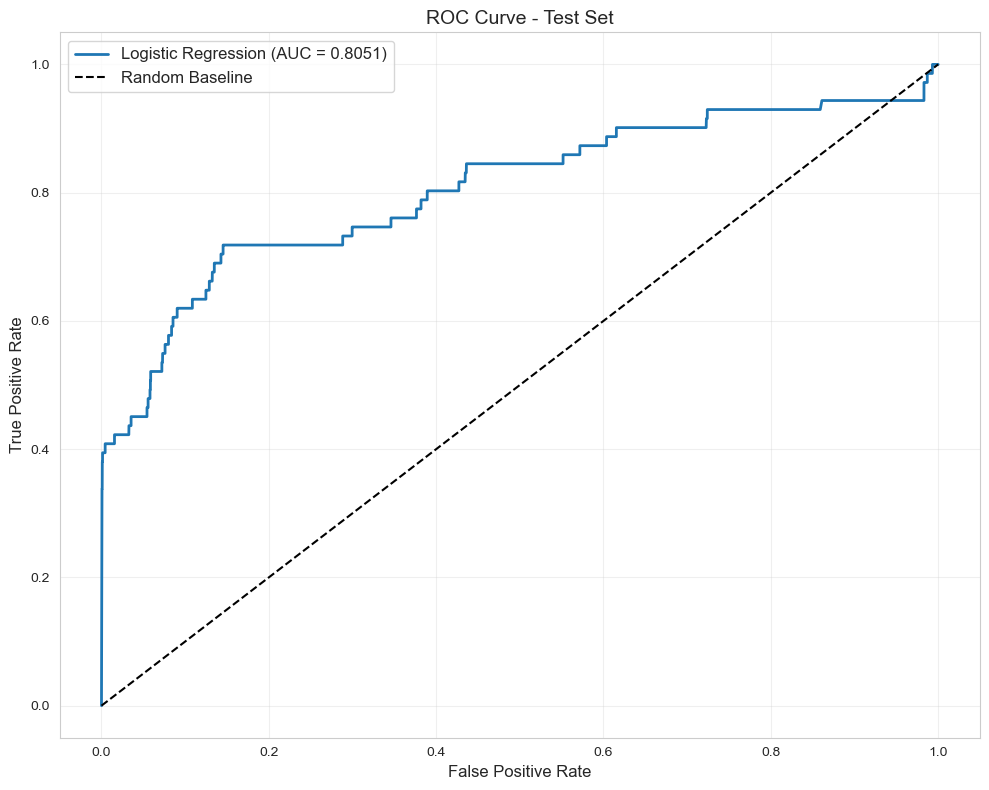

In [27]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_test):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Feature Importance

Top 20 Most Important Features:
                       feature  coefficient  abs_coefficient
                        in_num     1.588285         1.588285
       out_out_txs_degree_mean     1.359702         1.359702
     out_out_txs_degree_median     1.352401         1.352401
           out_out_BTC_min_sum     1.247938         1.247938
                       out_num     1.207017         1.207017
   in_num_output_addresses_sum    -0.970544         0.970544
  out_num_input_addresses_mean    -0.793987         0.793987
out_num_input_addresses_median    -0.649365         0.649365
          in_in_BTC_median_sum     0.564538         0.564538
             in_in_BTC_min_sum     0.559619         0.559619
            in_in_BTC_mean_sum     0.529343         0.529343
        out_out_BTC_min_median    -0.526199         0.526199
     out_out_BTC_median_median    -0.507650         0.507650
           in_out_BTC_min_mean     0.491141         0.491141
            in_in_BTC_max_mean     0.441509         0

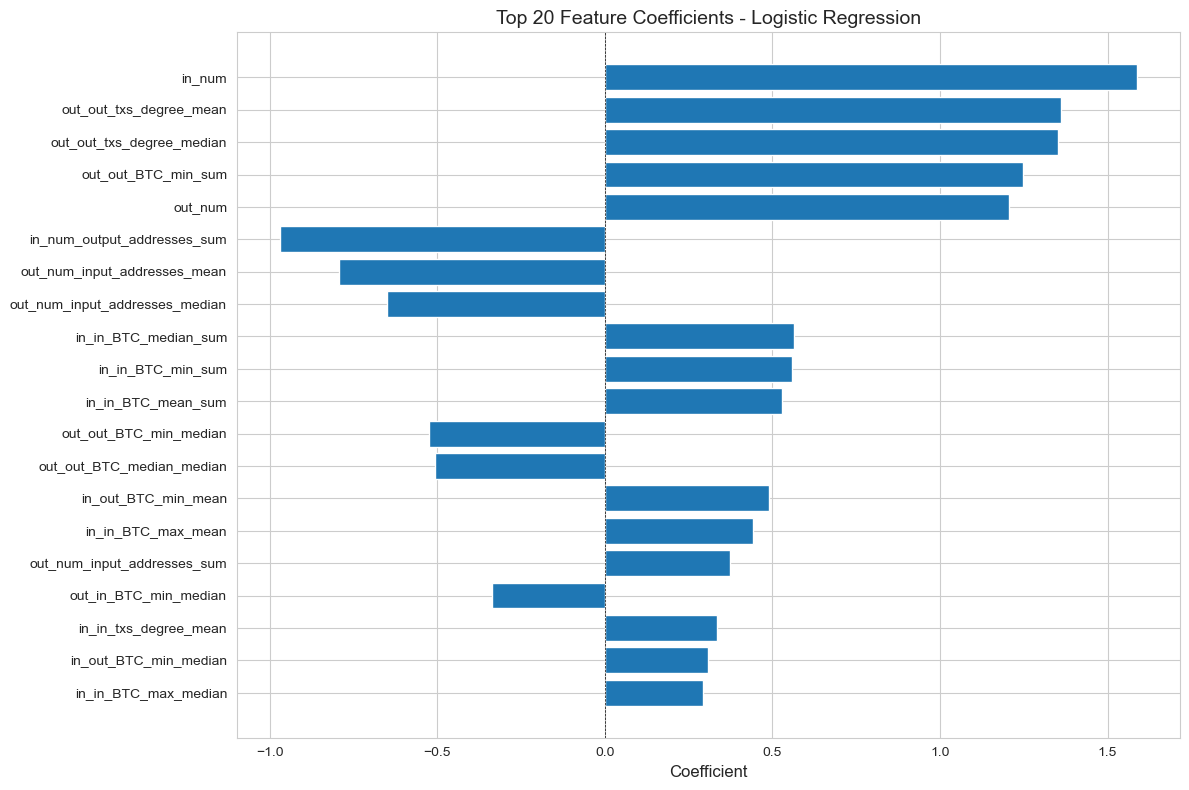

In [28]:
feature_cols = train_balanced_reduced_features.columns.tolist()

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Plot
top_n = 20
top_features = feature_importance.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient', fontsize=12)
plt.title(f'Top {top_n} Feature Coefficients - Logistic Regression', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Random Forest

In [29]:
# Train random forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
print("✓ Training complete")

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("RANDOM FOREST - TEST SET")
print("="*60)
print(classification_report(y_test, y_pred_rf, target_names=['No Future Illicit', 'Future Illicit']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

Training Random Forest...
✓ Training complete

RANDOM FOREST - TEST SET
                   precision    recall  f1-score   support

No Future Illicit       1.00      0.85      0.92    241362
   Future Illicit       0.00      0.65      0.00        71

         accuracy                           0.85    241433
        macro avg       0.50      0.75      0.46    241433
     weighted avg       1.00      0.85      0.92    241433

ROC-AUC: 0.8413


## XGBoost

In [30]:
# Train XGBoost
print("Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)
print("✓ Training complete")

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*60)
print("XGBOOST - TEST SET")
print("="*60)
print(classification_report(y_test, y_pred_xgb, target_names=['No Future Illicit', 'Future Illicit']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")

Training XGBoost...
✓ Training complete

XGBOOST - TEST SET
                   precision    recall  f1-score   support

No Future Illicit       1.00      0.81      0.89    241362
   Future Illicit       0.00      0.75      0.00        71

         accuracy                           0.81    241433
        macro avg       0.50      0.78      0.45    241433
     weighted avg       1.00      0.81      0.89    241433

ROC-AUC: 0.8491


## Compare

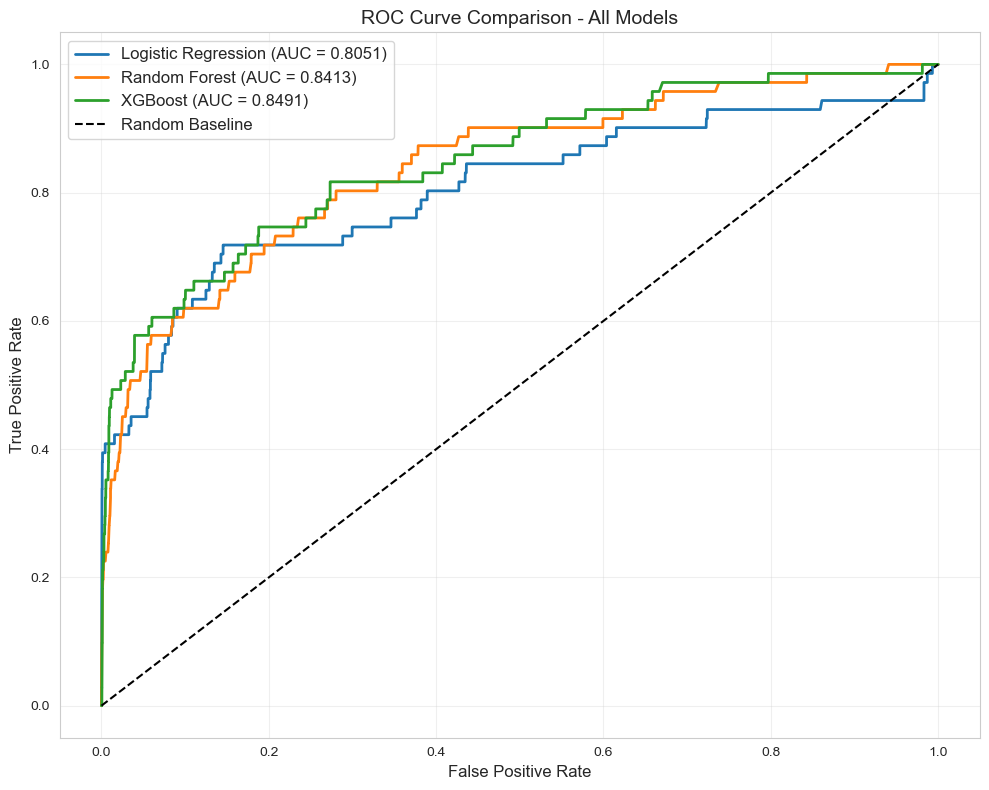

In [31]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_proba_test):.4f})')
plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.4f})')
plt.plot(fpr_xgb, tpr_xgb, linewidth=2, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - All Models', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()